# Image Classification Project

This notebook implements a machine learning project for classifying sports personalities using facial images. It utilizes:

- OpenCV for face detection and image processing
- Scikit-learn for machine learning models (SVM, Random Forest, Logistic Regression)
- Wavelet transforms for feature extraction
- Grid search for hyperparameter tuning

The goal is to accurately identify athletes like Maria Sharapova, Virat Kohli, Serena Williams, etc. from their facial images.

Key steps include:
1. Image preprocessing and face detection
2. Feature extraction using wavelet transforms 
3. Training multiple ML models
4. Model evaluation and selection
5. Saving the best model for deployment


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import cv2
%matplotlib inline

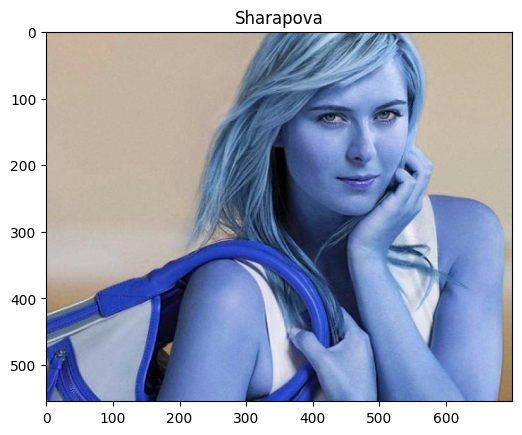

In [3]:
img = cv2.imread('./test_images/sharapova1.jpg') # read image by opencv
plt.imshow(img)  # displaying image
plt.title('Sharapova')
plt.show()

In [4]:
img.shape

(555, 700, 3)

In [5]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converting image to gray
gray_image.shape

(555, 700)

In [6]:
gray_image

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], shape=(555, 700), dtype=uint8)

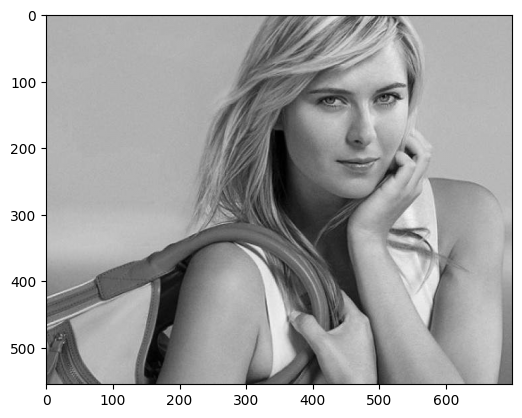

In [7]:
plt.imshow(gray_image, cmap='gray')  #displaying gray image
plt.show()

This code loads pre-trained OpenCV classifiers for face and eye detection, then uses them to detect faces in the grayscale image with scale factor 1.3 and minimum 5 neighbors for each candidate rectangle.


In [8]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
faces

array([[352,  38, 233, 233]], dtype=int32)

This cell extracts face coordinates (x,y,width,height) from the first detected face and displays them.


In [9]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(352), np.int32(38), np.int32(233), np.int32(233))

This code draws a green rectangle around a detected face in the image using OpenCV and displays it using matplotlib.


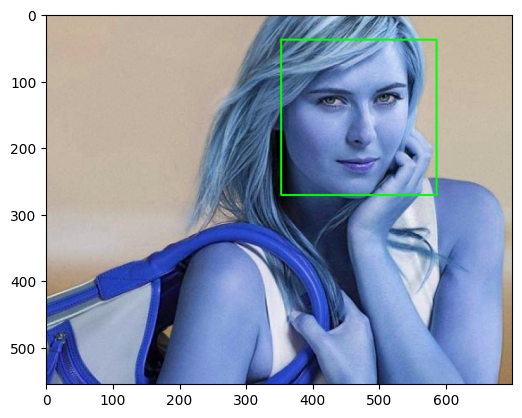

In [10]:
face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
plt.imshow(face_img)
plt.show()

This code detects faces and eyes in an image by drawing green rectangles around faces and red rectangles around eyes using OpenCV's cascade classifiers, then displays the result using matplotlib.


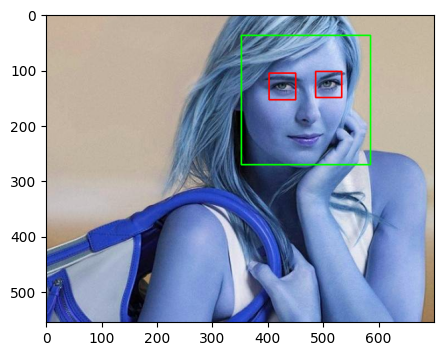

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
    roi_gray = gray_image[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (255,0,0), 2)
plt.figure(figsize=(5,5))
plt.imshow(face_img, cmap='gray')
plt.show()

This code displays the region of interest (ROI) containing a detected face from the original image:

- `roi_color` contains the cropped face region extracted from the full image
- `plt.imshow()` displays the image array using matplotlib
- `cmap='gray'` parameter specifies grayscale colormap for visualization
- `plt.show()` renders the plot on screen

The ROI was previously obtained by cropping the original image using face detection coordinates.


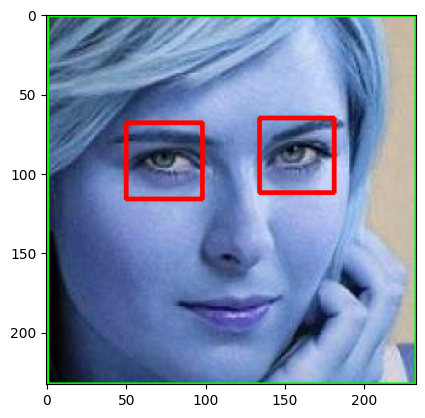

In [12]:
 plt.imshow(roi_color, cmap='gray')
 plt.show()

In [13]:
def get_cropped_image_2_eyes(image_path):
    ''' This function takes an image path and returns a cropped image if it contains 2 eyes.'''
    img = cv2.imread(image_path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray_image[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

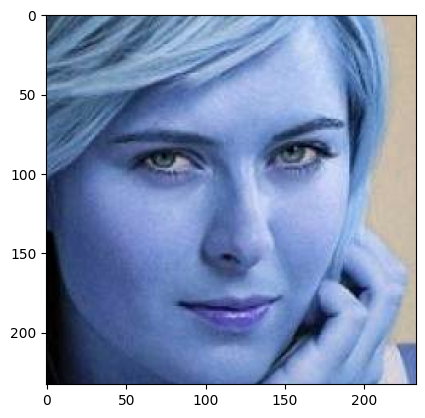

In [14]:
plt.imshow(get_cropped_image_2_eyes('./test_images/sharapova1.jpg'))
plt.show()

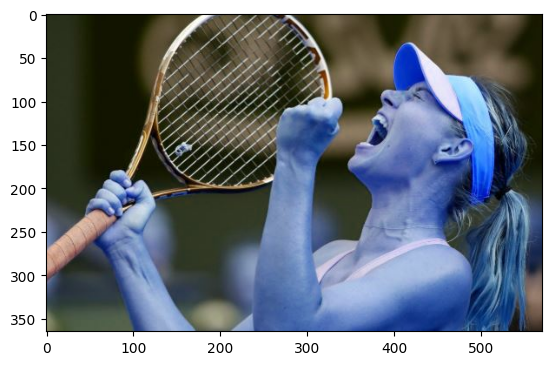

In [16]:
orginal_image_obstructed = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(orginal_image_obstructed)
plt.show()

In [17]:
sharapova2 = get_cropped_image_2_eyes('./test_images/sharapova2.jpg')
sharapova2

In [18]:
path_to_data = "./dataset/"
path_to_crop_image_data = "./dataset/cropped/"

This code scans a directory for subdirectories and stores their paths in a list:

1. `os.scandir(path_to_data)` iterates through entries in the specified directory path
2. `entry.is_dir()` checks if each entry is a directory (not a file)
3. `img_dir.append(entry.path)` adds the full path of each directory to the list
4. The code collects paths to subdirectories containing image data for different sports personalities

The resulting `img_dir` list will contain paths like:
- ./dataset/lionel_messi 
- ./dataset/maria_sharapova
- ./dataset/roger_federer
etc.


In [19]:
import os
img_dir = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dir.append(entry.path)

In [20]:
img_dir

['./dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

This code handles image preprocessing in two parts:

1. :
- Checks if a directory for cropped images exists
- If it exists, completely removes it and its contents using shutil.rmtree()
- Creates a fresh empty directory for storing cropped images

2. :
- Initializes empty lists/dictionaries to store processed image information
- For each celebrity directory in the dataset:
  - Gets celebrity name from directory path
  - Scans all images in that directory
  - Uses face detection to crop images containing 2 eyes
  - Creates subdirectory for that celebrity's cropped images
  - Saves cropped images with sequential numbering
  - Maintains dictionary mapping celebrities to their cropped image paths

The code essentially preprocesses the raw celebrity images by:
- Detecting and cropping faces with both eyes visible
- Organizing cropped images into celebrity-specific folders 
- Tracking file paths for further processing


In [21]:
import shutil
if os.path.exists(path_to_crop_image_data):
    shutil.rmtree(path_to_crop_image_data)
os.mkdir(path_to_crop_image_data)

In [22]:
cropped_img_dir = []
celebrity_file_nm_dict = {}
for img_dr in img_dir:
    count = 1
    celebrity_name = img_dr.split('/')[-1]
    celebrity_file_nm_dict[celebrity_name] = []
    for entry in os.scandir(img_dr):
        roi_colr = get_cropped_image_2_eyes(entry.path)
        if roi_colr is not None:
            cropped_folder = path_to_crop_image_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_img_dir.append(cropped_folder)
                print('generate folder:', cropped_img_dir)
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_colr)
            count += 1
            celebrity_file_nm_dict[celebrity_name].append(cropped_file_path)


generate folder: ['./dataset/cropped/lionel_messi']
generate folder: ['./dataset/cropped/lionel_messi', './dataset/cropped/maria_sharapova']
generate folder: ['./dataset/cropped/lionel_messi', './dataset/cropped/maria_sharapova', './dataset/cropped/roger_federer']
generate folder: ['./dataset/cropped/lionel_messi', './dataset/cropped/maria_sharapova', './dataset/cropped/roger_federer', './dataset/cropped/serena_williams']
generate folder: ['./dataset/cropped/lionel_messi', './dataset/cropped/maria_sharapova', './dataset/cropped/roger_federer', './dataset/cropped/serena_williams', './dataset/cropped/virat_kohli']


## Feature Engineering

In [23]:
import pywt
def w2d(img, mode = 'haar', level = 1):
    ''' This function takes an image array and returns a 2D wavelet transformed array.'''
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255;
    coeffs = pywt.wavedec2(imArray, mode, level = level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H

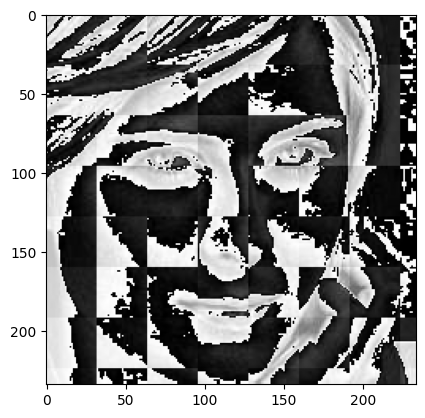

In [24]:
im_har = w2d(get_cropped_image_2_eyes('./test_images/sharapova1.jpg'), 'db1', 5)
plt.imshow(im_har, cmap='gray')
plt.show()

In [25]:
celebrity_file_nm_dict

{'lionel_messi': ['./dataset/cropped/lionel_messi/lionel_messi1.png',
  './dataset/cropped/lionel_messi/lionel_messi2.png',
  './dataset/cropped/lionel_messi/lionel_messi3.png',
  './dataset/cropped/lionel_messi/lionel_messi4.png',
  './dataset/cropped/lionel_messi/lionel_messi5.png',
  './dataset/cropped/lionel_messi/lionel_messi6.png',
  './dataset/cropped/lionel_messi/lionel_messi7.png',
  './dataset/cropped/lionel_messi/lionel_messi8.png',
  './dataset/cropped/lionel_messi/lionel_messi9.png',
  './dataset/cropped/lionel_messi/lionel_messi10.png',
  './dataset/cropped/lionel_messi/lionel_messi11.png',
  './dataset/cropped/lionel_messi/lionel_messi12.png',
  './dataset/cropped/lionel_messi/lionel_messi13.png',
  './dataset/cropped/lionel_messi/lionel_messi14.png',
  './dataset/cropped/lionel_messi/lionel_messi15.png',
  './dataset/cropped/lionel_messi/lionel_messi16.png',
  './dataset/cropped/lionel_messi/lionel_messi17.png',
  './dataset/cropped/lionel_messi/lionel_messi18.png',
  '

In [38]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_nm_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [39]:
x = []
y = []
for celebrity_name, celebrity_file_nm_list in celebrity_file_nm_dict.items():
    for celebrity_file_nm in celebrity_file_nm_list:
        img = cv2.imread(celebrity_file_nm)
        if img is None:
            continue
        scaled_raw_image = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img  = np.vstack((scaled_raw_image.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])


In [40]:
len(x[0])

4096

In [41]:
x = np.array(x).reshape(len(x), 4096).astype(float)
x.shape

(161, 4096)

In [42]:
x[0]

array([100., 129., 140., ..., 237., 234., 232.], shape=(4096,))

## Model Builing

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [45]:
data_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel="rbf", C=10))])
data_pipeline.fit(x_train, y_train)
data_pipeline.score(x_test, y_test)

0.8048780487804879

In [46]:
result_report = classification_report(y_test, data_pipeline.predict(x_test))
print(result_report)

              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.90      0.82      0.86        11
           2       0.75      0.50      0.60         6
           3       0.70      1.00      0.82         7
           4       0.77      1.00      0.87        10

    accuracy                           0.80        41
   macro avg       0.82      0.78      0.78        41
weighted avg       0.83      0.80      0.79        41



In [47]:
from sklearn.model_selection import GridSearchCV

### Hyperparamter Tunning by Grid Search

In [48]:
model_params = {
    'svm' : {
        'model':SVC(),
        'params':{
            'svc__C':[1, 5, 10],
            'svc__kernel':['rbf', 'linear'],
        }
    },
    'random_forest' : {
        'model':RandomForestClassifier(),
        'params':{
            #'randomforest__criterion':['gini', 'entropy'],
            'randomforestclassifier__n_estimators':[1,5, 10],
        }
    },
    'logistic_regression' : {
        'model':LogisticRegression(solver='liblinear'),
        'params':{
            'logisticregression__C':[1, 5, 10],
        }
    }
}

In [50]:
scores = []
best_estimator ={}
for model_name, model_info in model_params.items():
    pipe = make_pipeline(StandardScaler(), model_info['model'])
    clf = GridSearchCV(pipe, model_info['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model':model_name,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimator[model_name] = clf.best_estimator_

df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
df

C:\Users\abhis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\abhis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\abhis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multi

,model,best_score,best_params
0,svm,0.850000,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.716667,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.833333,{'logisticregression__C': 1}


In [51]:
best_estimator

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=1, kernel='linear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

### model Evaluation

In [52]:
best_estimator['svm'].score(x_test, y_test)

0.9024390243902439

In [53]:
best_estimator['random_forest'].score(x_test, y_test)

0.6585365853658537

In [54]:
best_estimator['logistic_regression'].score(x_test, y_test)

0.8292682926829268

In [55]:
best_clf = best_estimator['svm']


In [57]:
cm = confusion_matrix(y_test, best_clf.predict(x_test))
cm

array([[ 6,  0,  0,  1,  0],
       [ 0, 10,  1,  0,  0],
       [ 0,  1,  5,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  1,  0,  9]])

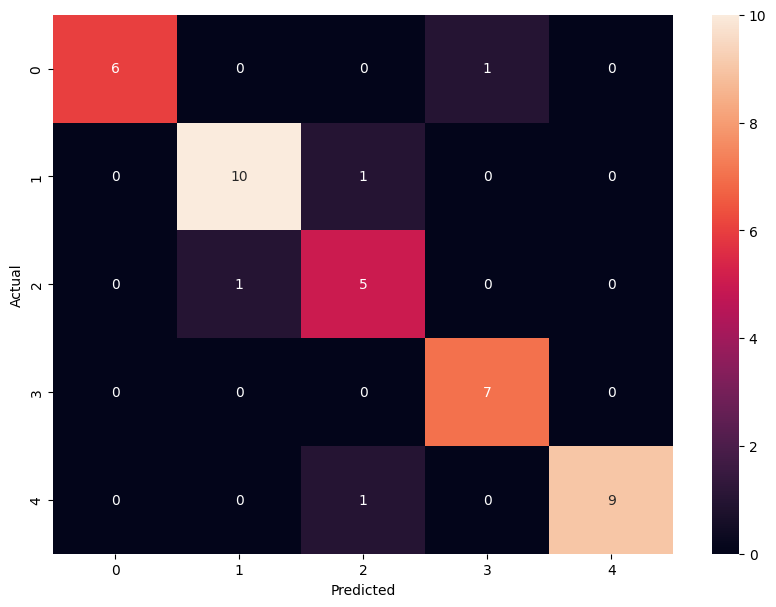

In [79]:
import seaborn as sns
plt.figure(figsize = (10, 7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show(5,5)

## Saving model in pickle file for real time use

In [66]:
!pip install joblib
import joblib

joblib.dump(best_clf, 'trained_model.pkl')

['trained_model.pkl']

In [67]:
import json
with open('class_dictionary.json', 'w') as f:
    f.write(json.dumps(class_dict))